<a href="https://colab.research.google.com/github/frag30041997/jupyter-one/blob/master/League_Of_Legends_Win_Chance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import seaborn as sns; sns.set
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def accuracy(preds,target):
  return (preds==target).sum()/len(target)


def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/high_diamond_ranked_10min.csv',encoding="ISO-8859-1",engine='python')
lol = df.iloc[0:300,:]
print(df.shape,lol.shape)

(9879, 40) (300, 40)


In [18]:
#Isolation
#target_feature_name = 'target_feature'
target= 'blueWins'
y = lol[target]
x = lol.drop(columns=target)


splits = train_test_split(x,y, train_size=0.55,stratify=y,random_state=100) #separe le dataset en deux parties 1 pour entrainement a la prediction et l'autre pour le test operationnel
                                              # stratify important car permet de récolter des reponses a comparer auxprediction de manière a tester le plus de cas possibles ( empeche de prendre ici que 1,2 ou 3 en réponse)

x_train = splits[0]
x_test = splits[1]
y_train = splits[2]
y_test = splits[3]

#Pipeline
pipeline_details = [('PCA', PCA(random_state=1337)),
                    ('RF', RF())]
pipeline = Pipeline(steps=pipeline_details)

#GridSearchCV
hyperparameters = {}
hyperparameters['PCA__n_components'] = [i for i in range(1, x_train.shape[1]+1,3)]
hyperparameters['RF__n_estimators']  = [i for i in range(70,150+1,20)]
print(hyperparameters)

hyperparameter_search = GridSearchCV(pipeline, hyperparameters, scoring='accuracy', cv=5)

hyperparameter_search.fit(x_train, y_train)

print('Meilleur score : {:.5f}'.format(hyperparameter_search.best_score_))
print('Meilleur paramètres : {}'.format(hyperparameter_search.best_params_))

{'PCA__n_components': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37], 'RF__n_estimators': [70, 90, 110, 130, 150]}
Meilleur score : 0.78182
Meilleur paramètres : {'PCA__n_components': 22, 'RF__n_estimators': 110}


In [19]:
#PCA
best_param_PCA = hyperparameter_search.best_params_['PCA__n_components']
pca = PCA(n_components=best_param_PCA)
pca.fit(x_train)
x_train_PCA = pca.transform(x_train)
x_test_PCA = pca.transform(x_test)

#RF
N=hyperparameter_search.best_params_['RF__n_estimators']
rf = RF(n_estimators=N)
rf.fit(x_train_PCA, y_train)

#Accuracy
preds = rf.predict(x_test_PCA)
print('Accuracy : ',accuracy(preds, y_test)*100,'%')

Accuracy :  80.74074074074075 %


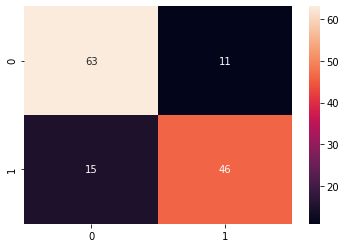

In [34]:
y_classifie = y.astype('category').cat.categories.tolist()
cm_train = confusion_matrix(y_test,y_pred=preds,labels=y_classifie)
show_cm(cm_train, y_classifie)